# ViT Model Testing w/ MNIST Dataset
Process:
> Split an image into patches and provide the sequence of linear embeddings of these patches as an input to a Transformer. Image patches are treated the same way as tokens (words) in an NLP application. We train
> the model on image classification in supervised fashion.

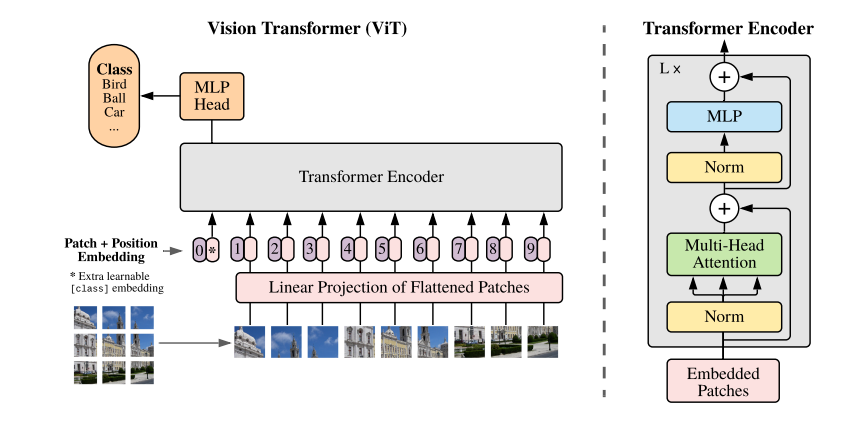

## Required Imports

In [1]:
import torch
from torch import nn

import pandas as pd
from torch import optim # for using ADAM
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit # tracking training time
from tqdm import tqdm # prgress bar

## Accuracy and BATCH_SIZE
Based on changing the value of BATCH_SIZE:
- 512 gives 94.02% (original value) in 410 seconds (approx 7 min)
- 256 gives 95%
- 64 gives 96.48%
- 32 gives 97.02%
- 8 gives 97.4%
- 4 gives 97.9% in 5701 seconds (approx 1 hr 35 min)
- 2 gives 97.8% in 11147 seconds (approx 3 hours)

keep decreasing the BATCH_SIZE as it uses more 3D processing of GPU, as increasing uses more VRAM

Higher the BATCH_SIZE value, the quicker the training, but less accurate. The smaller the value, more training time, better generalization (performance on unseen data), but more accurate. 

In [13]:
RANDOM_SEED = 42
BATCH_SIZE = 2 # number of samples propogated
EPOCHS = 40 # number of iterations of training dataset

LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
INPUT_CHANNELS = 1
NUM_HEADS = 8 # DECIDES HOW MANY ATTENTION HEADS WE WILL USE
DROPOUT = 0.001
HIDDEN_DIMENSION = 768 # HIDDEN DIMENSION OF MLP HEAD
ADAM_WEIGHT_DECAY = 0 # WEIGHT DECAY WE WILL GIVE TO THE OPTIMIZER, IN THE PAPER THE VALUE DOES NOT WORK AS WELL
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUMBER_ENCODERS = 4
EMBEDDED_DIMENSION = (PATCH_SIZE ** 2) * INPUT_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# see if gpu is detected
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else "cpu"

True


## Patch Embedding Class
Patch Embedding is the part that goes into the transformer encoder. Here, we convert the image to a sequence of patches and add positional embeddings.

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels = in_channels,
                out_channels = embed_dim,
                kernel_size = patch_size,
                stride = patch_size
            ),
            nn.Flatten(2)
        )
        
        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad = True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches + 1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)


    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1) #-1 means that the dimension is not mutable

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)

        x = self.position_embeddings + x # dont need this if .to(device) is enabled in sample tensor in ViT class????
        x = self.dropout(x)
        
        return x

# TESTING
model = PatchEmbedding(EMBEDDED_DIMENSION, PATCH_SIZE, NUM_PATCHES, DROPOUT, INPUT_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)

print(model(x).shape)

torch.Size([512, 50, 16])


## Vision Transformer Class
Here, we conbine the PatchEmbedding, the transformer encoder and the MLP (Multi-Layer Perceptron) Head for the classification to take place.

- Job for MLP Head:
> Takes the output from the transformer encoder and then maps it to the final 'class' predictions.

In [4]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead = num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :]) # taking the token only in the beginning
        return x

#TESTING
model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBEDDED_DIMENSION, NUMBER_ENCODERS, NUM_HEADS, HIDDEN_DIMENSION, DROPOUT, ACTIVATION, INPUT_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)


torch.Size([512, 10])


g:\ViT model test\env\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
g:\ViT model test\env\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


## Training on MNIST

In [5]:
train_df = pd.read_csv("G:/ViT model test/digit-recognizer/train.csv")
test_df = pd.read_csv("G:/ViT model test/digit-recognizer/test.csv")

In [ ]:
train_df.head() #testing the train.csv file

In [ ]:
test_df.head() #testing the test.csv file

In [8]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

## Defining Custom DataSet Classes
- MNISTtraining: for training the data
- MNISTvalidation: for validating the data
- MNISTsubmit: for submitting data to kaggle (not used)

In [9]:
class MNISTtraining(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15), # random image rotation. this is used as data augmentation, can be changed around based on the data
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index].reshape((28,28)).astype(np.uint8)
        label = self.labels[index]
        idx = self.indices[index]
        image = self.transform(image)
        return {'image': image, 'label': label, 'index': idx}



class MNISTvalidation(Dataset):
    def __init__(self, images, labels, indices):
        self.images = images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index].reshape((28,28)).astype(np.uint8)
        label = self.labels[index]
        idx = self.indices[index]
        image = self.transform(image)
        return {'image': image, 'label': label, 'index': idx}


# wont have any labels as that is what we are trying to predict
class MNISTsubmit(Dataset):
    def __init__(self, images, indices):
        self.images = images
        self.indices = indices
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index].reshape((28,28)).astype(np.uint8)
        idx = self.indices[index]
        image = self.transform(image)
        return {'image': image, 'index': idx}

--------------------
--------------------


<Figure size 640x480 with 0 Axes>

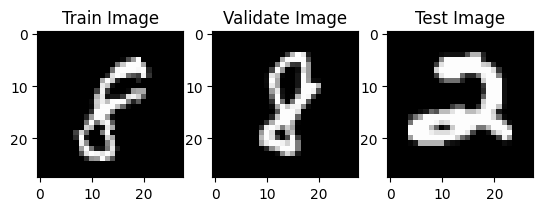

In [10]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTtraining(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
# print(len(train_dataset))
# print(train_dataset[0])
axarr[0].imshow(train_dataset[0]['image'].squeeze(), cmap='gray')
axarr[0].set_title("Train Image")

print('-' * 20)

val_dataset = MNISTvalidation(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
# print(len(val_dataset))
# print(val_dataset[0])
axarr[1].imshow(val_dataset[0]['image'].squeeze(), cmap='gray')
axarr[1].set_title('Validate Image')

print('-' * 20)

test_dataset = MNISTsubmit(test_df.values.astype(np.uint8), test_df.index.values) # dont need iloc as first column is not 'label'
# print(len(test_dataset))
# print(test_dataset[0])
axarr[2].imshow(test_dataset[0]['image'].squeeze(), cmap='gray')
axarr[2].set_title('Test Image')


plt.show()

## DataLoaders
We set shuffle = True as we malke sure model does not learn any dependant patterns

In [11]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

## Train Loop

In [ ]:
# this is copied

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())
        
        loss = criterion(y_pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)         
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)
            
            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())
            
            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Training Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Validity Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Training Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Validity Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

In [14]:
torch.cuda.empty_cache()

In [15]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        
        outputs = model(img)
        
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 14000/14000 [00:35<00:00, 391.71it/s]


<Figure size 640x480 with 0 Axes>

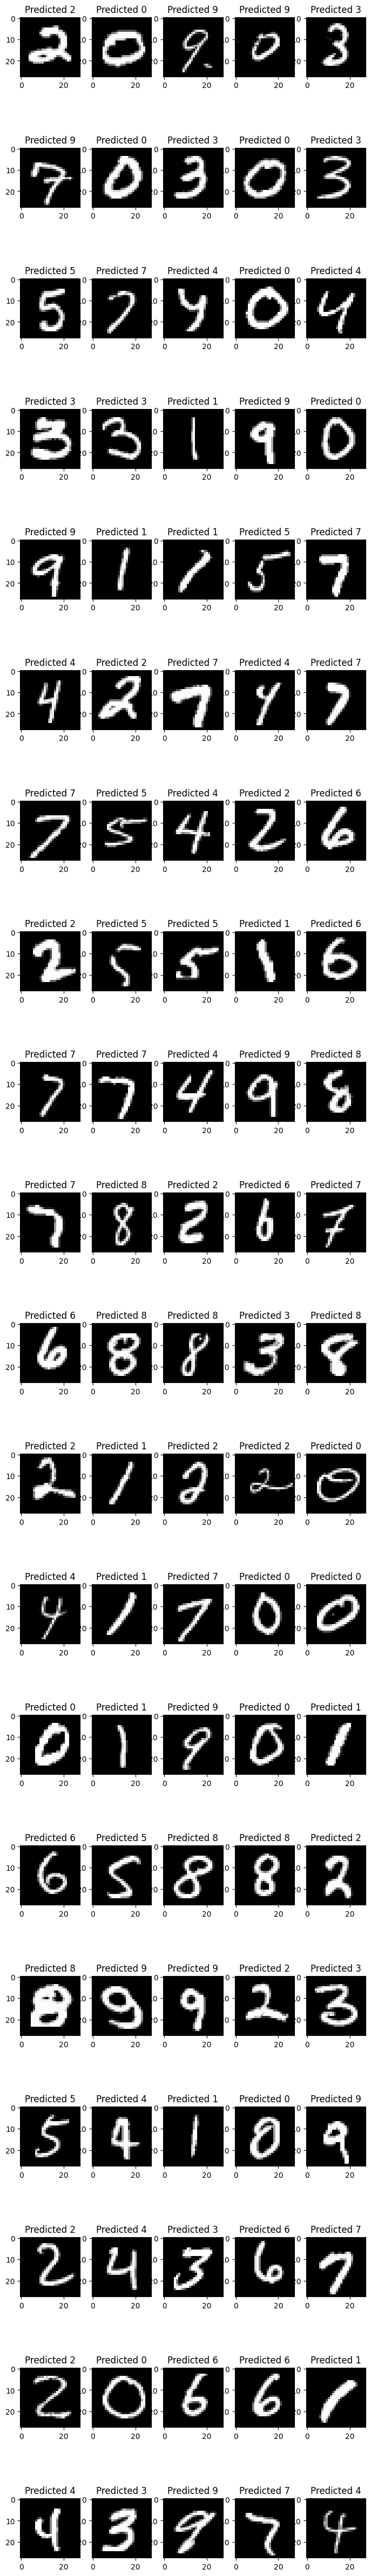

In [16]:
plt.figure()
f, axarr = plt.subplots(20, 5)
f.subplots_adjust(left=4, top=20, bottom=10, right=5)
counter = 0
for i in range(20):
    for j in range(5):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1